In [57]:
from pivot_points import plot_data
import pandas as pd
import yfinance as yf

import plotly.express as px
import numpy as np


In [58]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)


Atkreipkite dėmesį, kad šis projektas nesuteikia asmeninės investavimo patarimų, ir aš nesu kvalifikuotas licencijuotas investavimo patarėjas. Visi čia rasti duomenys skirti tik pramogai arba švietimo projektų tikslams ir neturėtų būti traktuojami kaip asmeniniai investavimo, prekevimo patarimai.

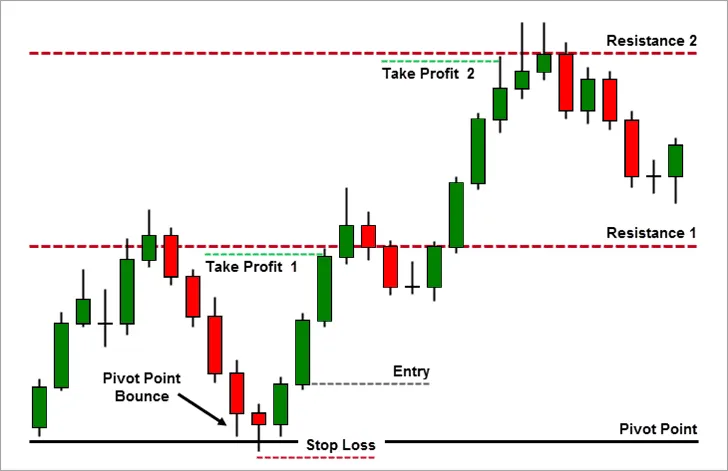

In [59]:
from PIL import Image as PILImage
from IPython.display import display

webp_image_path = '/Users/lokys/Visual Code/Projektas_FX/pivots.webp'

# Uzkrauna ir konvertuoja  WebP nuotrauka i PNG
img = PILImage.open(webp_image_path)
png_image_path = '/Users/lokys/Visual Code/Projektas_FX/pivots.png'
img.save(png_image_path, 'PNG')

display(PILImage.open(png_image_path))



In [60]:
data = pd.DataFrame(plot_data)
data['Signal'] = ''
data['Position'] = 0
data['Equity'] = 0.0

position = 0
initial_equity = 1000
equity = initial_equity

pip_value = 10
lots = 0.1
pips = 0

stats = []
# data.reset_index(inplace=True)

trade_counter = 0  # Skaiciuoja trades per pivot point
prev_pp = None  # seka priestai pivot point

for i in range(len(data)):
    date = data['Datetime'].iloc[i]
    close = data['Close'].iloc[i]
    pp = data['PP'].iloc[i]
    pp = data['PP'].iloc[i]
    r1 = data['R1'].iloc[i]
    r2 = data['R2'].iloc[i]

    if prev_pp != pp:  # resetinu skaiciavima for new pivot point
        trade_counter = 0 
        prev_pp = pp

    
    if trade_counter < 3:
        if position == 0 and close > pp:
            data.at[i, 'Signal'] = 'Buy'
            position = 1
            trade_counter += 1
            entry_price = close
            stats.append((date, equity))
        elif position == 1 and close > r1:
            data.at[i, 'Signal'] = 'Sell Half at R1'
            pips = (close - entry_price) * 100
            equity += pips * pip_value * lots * 0.5
            position = 0.5
            trade_counter += 1
            stats.append((date, equity))
        elif position == 0.5 and close > r2:
            data.at[i, 'Signal'] = 'Sell Remaining at R2'
            pips = (close - entry_price) * 100
            equity += pips * pip_value * lots * 0.5
            position = 0
            trade_counter += 1
            stats.append((date, equity))
        elif position != 0 and close < pp:
            data.at[i, 'Signal'] = 'Sell All (Below PP)'
            pips = (close - entry_price) * 100
            equity += pips * pip_value * lots
            position = 0
            trade_counter += 1
            stats.append((date, equity))

    data.at[i, 'Position'] = position
    data.at[i, 'Equity'] = equity








In [61]:
print("Date, Equity Value for Each Trade")
print("-" * 40)
for date, equity_value in stats:
    print(f"{date}, ${equity_value:.2f}")
print(f"\nInitial Equity: ${initial_equity}")
print(f"Final Equity: ${equity:.2f}")

Date, Equity Value for Each Trade
----------------------------------------
2023-01-23 00:00:00+00:00, $1000.00
2023-01-30 03:00:00+00:00, $1047.60
2023-01-30 08:00:00+00:00, $1047.60
2023-01-31 01:00:00+00:00, $1016.90
2023-02-06 00:00:00+00:00, $1016.90
2023-02-07 08:00:00+00:00, $881.00
2023-02-07 11:00:00+00:00, $881.00
2023-02-13 00:00:00+00:00, $788.60
2023-02-13 05:00:00+00:00, $788.60
2023-02-14 14:00:00+00:00, $872.95
2023-02-23 18:00:00+00:00, $1029.45
2023-02-23 19:00:00+00:00, $1029.45
2023-02-24 00:00:00+00:00, $1012.55
2023-02-27 00:00:00+00:00, $1012.55
2023-02-27 05:00:00+00:00, $1000.45
2023-02-27 08:00:00+00:00, $1000.45
2023-03-06 00:00:00+00:00, $1056.15
2023-03-06 08:00:00+00:00, $1056.15
2023-03-06 10:00:00+00:00, $1051.55
2023-03-15 00:00:00+00:00, $1051.55
2023-03-15 01:00:00+00:00, $1043.65
2023-03-15 02:00:00+00:00, $1043.65
2023-03-20 00:00:00+00:00, $778.05
2023-03-21 10:00:00+00:00, $778.05
2023-03-21 14:00:00+00:00, $752.15
2023-03-27 07:00:00+01:00, $752.1

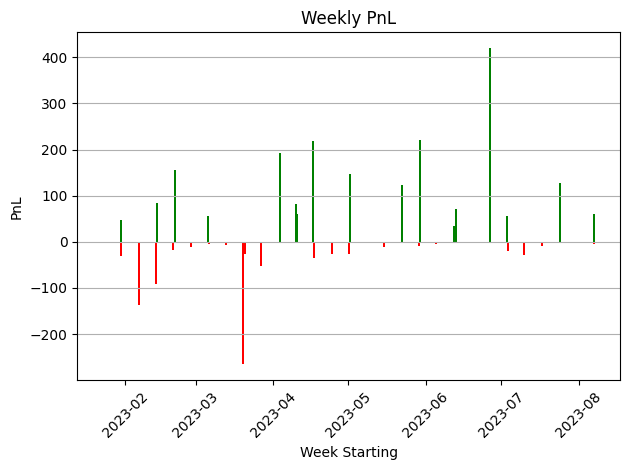

In [62]:
import matplotlib.pyplot as plt

# istraukiu datas, equities is stats listo
dates = [item[0] for item in stats]
equities = [item[1] for item in stats]
daily_pnl = [equities[0] - initial_equity] + [equities[i] - equities[i-1] for i in range(1, len(equities))]

# Funkcija istraukti data naujos savaites
def get_week_start(date):
    return date - pd.Timedelta(days=date.weekday())

# sugrupuoju savaitinius PnL duomenis
weekly_pnl = {}
for i, date in enumerate(dates):
    week_start = get_week_start(date)
    if week_start not in weekly_pnl:
        weekly_pnl[week_start] = 0
    weekly_pnl[week_start] += daily_pnl[i]

# istraukiu data 
weeks = list(weekly_pnl.keys())
weekly_pnl = list(weekly_pnl.values())


plt.bar(weeks, weekly_pnl, color=['g' if pnl >= 0 else 'r' for pnl in weekly_pnl])
plt.title('Weekly PnL')
plt.xlabel('Week Starting')
plt.ylabel('PnL')
plt.xticks(rotation=45)
plt.grid(axis='y')


plt.tight_layout()
plt.show()



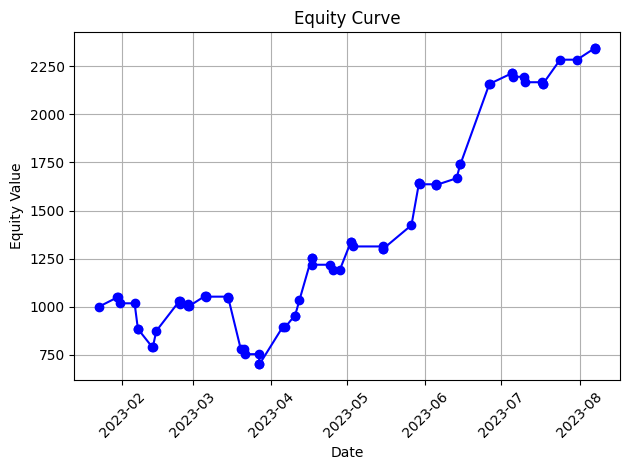

In [63]:
import matplotlib.pyplot as plt

# istraukiu dates and equities from the stats list
dates = [item[0] for item in stats]
equities = [item[1] for item in stats]


plt.plot(dates, equities, marker='o', linestyle='-', color='b')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.xticks(rotation=45)
plt.grid(True)


plt.tight_layout()
plt.show()


In [64]:
# suskaiciuoja PnL after kiekvieno trade
pnl_per_trade = [equities[0] - initial_equity] + [equities[i] - equities[i-1] for i in range(1, len(equities))]

# suskaiciuoja statistika 
total_trades = len(pnl_per_trade)
profit_trades = len([pnl for pnl in pnl_per_trade if pnl > 0])
loss_trades = len([pnl for pnl in pnl_per_trade if pnl < 0])
break_even_trades = total_trades - profit_trades - loss_trades

max_profit = max(pnl_per_trade)
max_loss = min(pnl_per_trade)
avg_profit = sum(pnl for pnl in pnl_per_trade if pnl > 0) / profit_trades if profit_trades != 0 else 0
avg_loss = sum(pnl for pnl in pnl_per_trade if pnl < 0) / loss_trades if loss_trades != 0 else 0


print("Total Trades:", total_trades)
print("Profit Trades:", profit_trades)
print("Loss Trades:", loss_trades)
print("Break-even Trades:", break_even_trades)
print("Max Profit:", max_profit)
print("Max Loss:", max_loss)
print("Average Profit:", avg_profit)
print("Average Loss:", avg_loss)



Total Trades: 70
Profit Trades: 17
Loss Trades: 20
Break-even Trades: 33
Max Profit: 419.7998046875
Max Loss: -265.6005859375
Average Profit: 127.05585255342372
Average Loss: -40.99510192871094
